In [1]:
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from binance.client import Client
from binance import enums

In [2]:
# Your API key and secret
API_KEY = ""
API_SECRET = ""

In [3]:
client = Client(API_KEY, API_SECRET)

In [40]:
# List of pairs you want to track
pairs = [
    ('BTC', 'USDT'),
    ('ETH', 'USDT'),
    ('XRP', 'USDT'),
    ('LTC', 'USDT'),
    ('BNB', 'USDT')
]
# https://python-binance.readthedocs.io/en/latest/genindex.html
# Kline/candlestick interval
# Fetch double of that to display in order to calculate windows correctly
interval = enums.KLINE_INTERVAL_1DAY
limit = 60

In [180]:
import importlib
import cryptoz
importlib.reload(cryptoz)

import cryptoz.binance
importlib.reload(cryptoz.binance)
from cryptoz.binance import BinanceHelper

import cryptoz.utils
importlib.reload(cryptoz.utils)
from cryptoz import utils

import cryptoz.plots
importlib.reload(cryptoz.plots)
from cryptoz import plots

import cryptoz.stats
importlib.reload(cryptoz.stats)
from cryptoz import stats

In [48]:
binance = BinanceHelper(client)

## Data

In [30]:
ohlcvs = binance.get_multiple_pair_ohlcv(pairs, interval, limit=limit)

In [33]:
ohlcvs.keys()

dict_keys([('BTC', 'USDT'), ('ETH', 'USDT'), ('XRP', 'USDT'), ('LTC', 'USDT'), ('BNB', 'USDT')])

## Basic statistics

In [177]:
utils.reverse_scale(pd.DataFrame([1, 2, 3, 4, 7])).values.flatten()

array([7, 6, 5, 4, 1])

In [186]:
utils.classify_arr(np.array([-3, -2, -1, 0, 1, 2, 3]), [1, 3], bipolar=False)

array([0, 0, 0, 0, 1, 1, 2])

### Price development

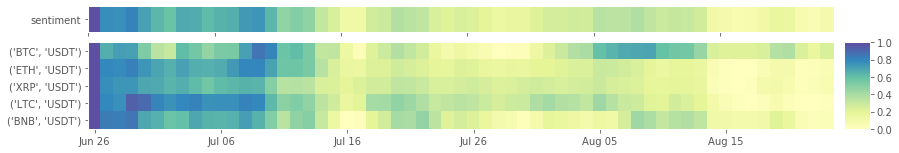

In [147]:
# Select column from each OHLCV
df = utils.reduce_group_to_df(ohlcvs, 'M')

# We want to somehow compare prices of all assets
# Thus let's normalize the prices based on their performance
# 1 would mean that this time step is the the all time high (ATH)
df = utils.normalize(df, 'minmax')

# Plot price evolution (i.e. price development heatmap)
# Rank by the latest price performance
plots.evolution(df)

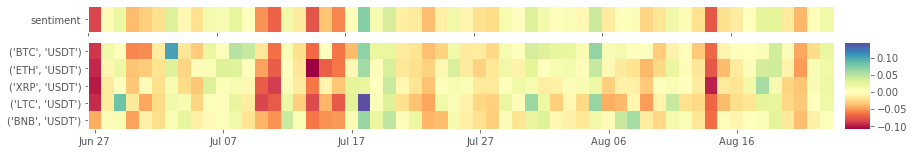

In [148]:
# Percentage change between the current and a prior price.
df = utils.reduce_group_to_df(ohlcvs, 'M')
df = df.pct_change().dropna()

plots.evolution(df)

### Price volatility

In [51]:
# Normalized volatility of each pair
df = utils.reduce_group_to_df(ohlcvs, 'M')
df = df.std() / df.mean()
df.sort_values()

BTC  USDT    0.076999
BNB  USDT    0.082994
XRP  USDT    0.148737
LTC  USDT    0.168790
ETH  USDT    0.178696
dtype: float64

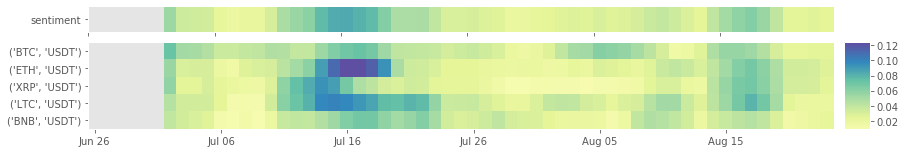

In [149]:
# Show development of the normalized volatility (smoothed)
df = utils.reduce_group_to_df(ohlcvs, 'M')
df = df.rolling(7).std() / df.rolling(7).mean()

plots.evolution(df)

## Volume

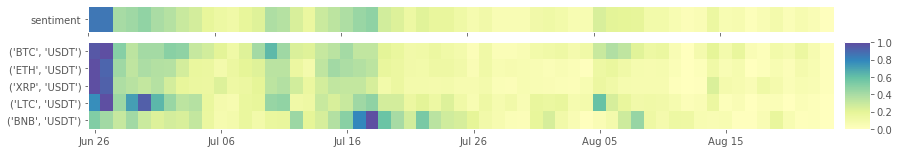

In [150]:
# Compare the development of volume for different pairs
df = utils.reduce_group_to_df(ohlcvs, 'V')
df = utils.normalize(df, 'minmax')

plots.evolution(df)

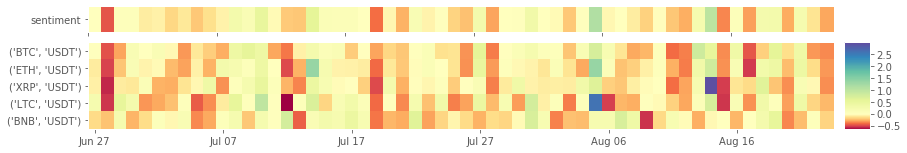

In [151]:
# Percentage change between the current and a prior volume.
df = utils.reduce_group_to_df(ohlcvs, 'V')
df = df.pct_change().dropna()

plots.evolution(df)

# Drawdown from peak

In [75]:
# Drawdown now
stats.dd.now(ohlcvs)

BTC  USDT    0.256621
BNB  USDT    0.287437
XRP  USDT    0.446276
LTC  USDT    0.459422
ETH  USDT    0.473991
dtype: float64

In [178]:
# Visualize the drawdown development across the pairs andtime scale
df = stats.dd.from_group(ohlcvs)

plots.evolution(df, cmap=plt.cm.cividis_r, norm=None, rank='last')

AttributeError: module 'cryptoz.stats.dd' has no attribute 'from_group'

# correlation

In [ ]:
window = 20
base_pair = 'BTC/USDT'

df = utils.to_df(ohlc, 'C').pct_change().dropna()
df = stats.corr.rolling(df, window=window)
regex = re.compile(r'(%s-.+)' % base_pair)
df = df[list(filter(regex.search, df.columns))]
df.columns = list(map(lambda x: re.sub(r'(/%s)' % base_pair.split('/')[1], '', x), df.columns))
df.dropna(inplace=True)
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.gist_earth, rank='last')

df.plot(figsize=(14, 8), cmap=plt.cm.tab20)
plt.show()

# anomaly detection

## price

In [ ]:
window = 20
levels = [1, 2, 3, 4, 5]

df = utils.to_df(ohlc, 'C')
df = utils.rolling_normalize(df, 'std', window)
df.dropna(inplace=True)
df = utils.classify(df, levels, bipolar=True)
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## volume

In [ ]:
window = 20
levels = [1, 2, 3, 4, 5]

df = utils.to_df(ohlc, 'V')
df = utils.rolling_normalize(df, 'std', window)
df.dropna(inplace=True)
df = utils.classify(df, levels, bipolar=True)
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

# oscillators

## *RSI*

In [ ]:
def RSI(df, window):
    delta = df.diff().dropna()
    up, down = delta * 0, delta * 0
    pos_mask = delta > 0
    neg_mask = delta < 0
    up[pos_mask] = delta[pos_mask]
    down[neg_mask] = -delta[neg_mask]
    up.iloc[window - 1] = up.iloc[:window].mean()
    up = up.iloc[window - 1:]
    down.iloc[window - 1] = down.iloc[:window].mean()
    down = down.iloc[window - 1:]
    rs = up.ewm(com=window - 1, adjust=False).mean() / down.ewm(com=window - 1, adjust=False).mean()
    rsi = 100 - 100 / (1 + rs)
    return rsi.reindex(df.index)

In [ ]:
window = 20
oversold = 30
overbought = 70

df = utils.to_df(ohlc, 'C')
df = RSI(df, window)
df = utils.trunk(df, [oversold, overbought])
df = utils.rescale(df, [-1, 1])
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## *CCI*

In [ ]:
def cci(df, period):
    # (Typical Price  -  20-period SMA of TP) / (.015 x Mean Deviation)
    tp_sma = df.rolling(period).mean()
    md = df.rolling(period).apply(lambda a: np.fabs(a - a.mean()).mean())
    return (df - tp_sma) / (.015 * md)

In [ ]:
window = 20
oversold = -300
overbought = 300

df = utils.to_df(ohlc, 'C')
df = cci(df, window)
df = utils.trunk(df, [oversold, overbought])
df = utils.rescale(df, [-1, 1])
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

# signals

## *EMA crossover*

In [ ]:
def ema_crossover(df, ema_fast, ema_slow):
    fast = df.ewm(span=ema_fast, adjust=False).mean()
    slow = df.ewm(span=ema_slow, adjust=False).mean()
    df = fast - slow
    df[df > 0] = 1
    df[df < 0] = -1
    df = df.fillna(0)
    df = df.diff().dropna()
    pos_mask = df == 2
    neg_mask = df == -2
    df[pos_mask] = 1
    df[neg_mask] = -1
    df[~neg_mask & ~pos_mask] = 0
    return df

In [ ]:
fast_window = 7
slow_window = 25

df = utils.to_df(ohlc, 'M')
df = ema_crossover(df, fast_window, slow_window)
df = utils.cut_df(df, display_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## *BollingerBand*

### How wide is the BB?

In [ ]:
def BB(df, window, k):
    sma = df.rolling(window=window).mean()
    std = df.rolling(window=window).std()
    BOLU = sma + std * k
    BOLD = sma - std * k
    return BOLD, BOLU

def corridor(BOLD, BOLU):
    return BOLU - BOLD

In [ ]:
window = 20
k = 2

df = utils.to_df(ohlc, 'C')
df = corridor(*BB(df, window, k)).dropna()
df = utils.rolling_normalize(df, 'mean', window).dropna()
df1 = utils.cut_df(df, display_window)

plot.evolution(df1, plt.cm.Spectral_r, plot.midpoint_norm(0), rank='last')

### Does the price exceed the BB?